In [17]:
from IPython.display import Image
from pathlib import Path

In [18]:
# Form the paths for different files
BASE_DIR = Path.cwd()
FIGURES_DIR = BASE_DIR / "data"/ "figures"

# I-GUIDE Summer School 2025 - Team 2
# GeoAI for Burn Area Analysis and Fire Risk Mapping in the Pantanal Wetlands

## Introduction

In June 2024, the Pantanal wetlands—a UNESCO World Heritage site and one of the planet’s most biodiverse ecosystems—experienced a wildfire crisis of unprecedented scale. Over 1.3 million hectares burned, an area more than eight times the size of London, marking the most severe early-season fire activity on record.

This disaster was driven by the convergence of extreme drought, strong winds, and land-use changes such as pasture expansion. Climate change amplified the event, increasing fire intensity by ~40% and making such extreme events 4–5 times more likely.

The impacts were severe:
- Wildlife deaths and habitat destruction in one of Earth’s richest ecosystems
- Respiratory health impacts in vulnerable populations, especially children and the elderly
- Loss of agricultural productivity and damage to infrastructure
- With 85% of burned areas on private lands, local livelihoods were directly affected

Looking ahead, projections indicate a hotter, drier Pantanal, with Daily Severity Rating (DSR) values ~40% higher, making wildfires harder to suppress and more likely to spread rapidly. Severe fire weather is becoming the new normal—demanding innovative, predictive tools for early warning, resource allocation, and long-term adaptation.

## Project Goal

We aim to develop a GeoAI-powered system to map and predict wildfire burn areas in the Pantanal wetlands, integrating multi-source datasets—remote sensing, climate reanalysis, and land-use data—to answer two key questions:
1. How do environmental and land-use factors influence burn extent?
2. Can GeoAI enhance early-stage fire risk mapping to support proactive management?

## Datasets

- Burn Area – [MODIS MCD64A1 v6.1](https://modis.gsfc.nasa.gov/data/dataprod/mod45.php) (downloaded from NASA AppEEARS), 500 m, high-confidence burns
- Land Cover – [ESA WorldCover](https://www.arcgis.com/home/item.html?id=cfcb7609de5f478eb7666240902d4d3d) (downloaded from ArcGIS Living Atlas), annual 2017–2024
- Elevation – [NASADEM](https://www.earthdata.nasa.gov/data/catalog/lpcloud-nasadem-hgt-001), 30 m resolution (downloaded from NASA EarthDataSearch)
- Climate Variables – [ERA5-Land hourly reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview): temperature, dewpoint, precipitation, U/V wind, soil moisture, surface pressure (downloaded from the Copernicus Climate Change Service)

## Study region and time frame

- Start Date: 05-01-2024; End Date: 07-31-2024
- North: -13°, West: -61°, South: -24°, East: -52°

# Step 1: Background & Data Preprocessing

- Pantanal 2024 wildfire timeline with key statistics
- Maps of study region and fire extent
- Dataset previews: MODIS burn area, ESA WorldCover, NASADEM elevation, ERA5 climate
- Spatial and temporal patterns (time series plots, heatmaps, maps)

# Step 2: Burn Occurence Modeling

**Problem Setup**

For the baseline, we treat each pixel–day record as an independent sample rather than as part of a spatiotemporal sequence.

- Target variable: Burn occurrence (burn = 1 if pixel burned on that day, else 0)
- Features: Environmental, climatic, and land-use variables aggregated at the pixel level
- Assumption: No explicit temporal dependence — the model learns from correlations between conditions and burn occurrence

This approach provides a quick benchmark for predictive performance before moving to sequence-based deep learning (e.g., ConvLSTM).

**Training Data**
- Positive samples: Pixels labeled as burned (from MODIS MCD64A1 high-confidence detections)
- Negative samples: Pixels with no burn activity on the same date
- Sampling strategy: Class imbalance is severe (burn : non-burn ≈ 1 : 100), so we:
    - Use stratified sampling to limit the number of non-burn samples per burn sample
    - We apply class weights in the loss function

 **Model Choice**

Our approach focuses on understanding how different feature sets influence predictive power for burn occurrence. We compare three interpretable classifiers:  

- **Random Forest (RF)** – Captures nonlinear relationships and provides clear feature importance rankings.  
- **XGBoost** – A gradient boosting approach that often improves performance on structured datasets.  
- **TabNet** – A deep tabular learning model that leverages attention to identify important features while remaining interpretable.  

 **Purpose of Comparison**
- **Feature-driven narrative** – Shift focus from achieving the highest possible accuracy to understanding how each feature set contributes to model performance.  
- **Model diversity** – Evaluate tree-based (RF, XGBoost) and deep learning (TabNet) approaches under the same conditions.  
- **Progressive feature integration** – Assess models across three datasets:  
  1. **Basic Features (BF)** – Core environmental and climatic variables:  
     `['land_cover', 'dem', 't2m', 'd2m', 'u10', 'v10', 'tp', 'swvl1', 'sp']`  
  2. **BF + Previous Burn History (PBH)** – Adds pixel-level burn history using a 5×5 kernel.  
  3. **BF + PBH + AlphaEarth Embeddings (AE)** – Incorporates high-dimensional Earth observation embeddings for richer spatial-temporal context.  
- **Cross-model evaluation** – Compare RF, XGBoost, and TabNet across all three feature sets to determine which features most improve predictive skill and how performance trends vary by model type.  


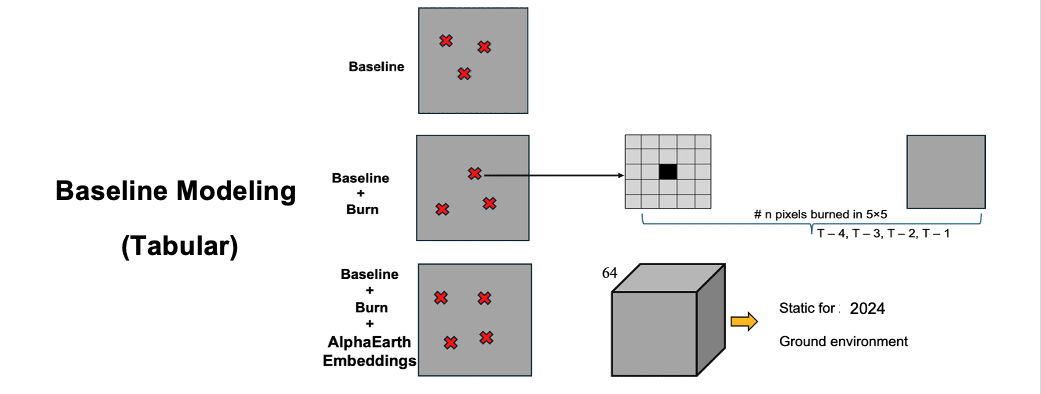

In [19]:
Image(filename=FIGURES_DIR / "baseline.png")

## Burn Occurence Modeling

### Training

**Table 1.** Baseline model performance comparison across three feature sets—Basic, Basic + Previous Burn History, and Basic + Previous Burn History + AlphaAI embeddings—using Random Forests, XGBoost, and TabNet. Metrics shown are Precision, Recall, and F1-score on 30% test data.

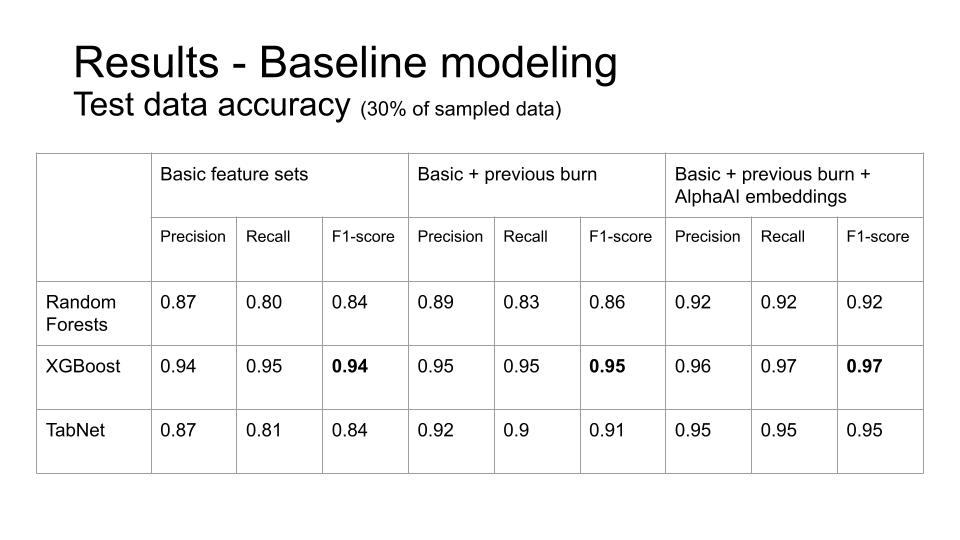

In [11]:
Image(filename=FIGURES_DIR / "Burn_Occurence_Results.jpg")

Results highlight consistent performance gains from adding previous burn history, with the largest boost achieved when incorporating AlphaAI embeddings. XGBoost consistently outperforms other models across all feature sets.

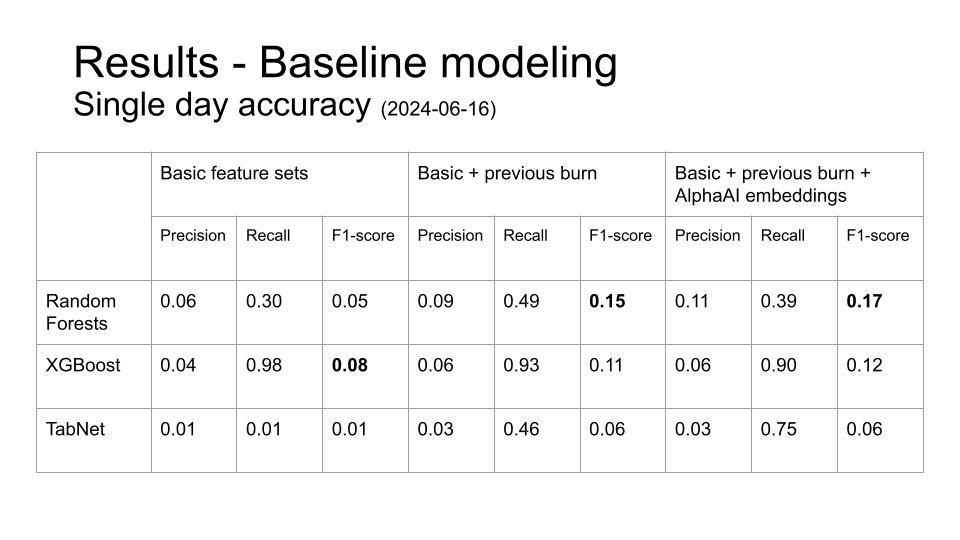

In [14]:
Image(filename=FIGURES_DIR /"Burn_Occurence_Results_SDA.jpg")

Table 2. Baseline model performance comparison across three feature sets—Basic, Basic + Previous Burn History, and Basic + Previous Burn History + AlphaAI embeddings—using Random Forests, XGBoost, and TabNet. Metrics shown are Precision, Recall, and F1-score on a single day application cropped to the largest detected burn cluster.

### Interpretation

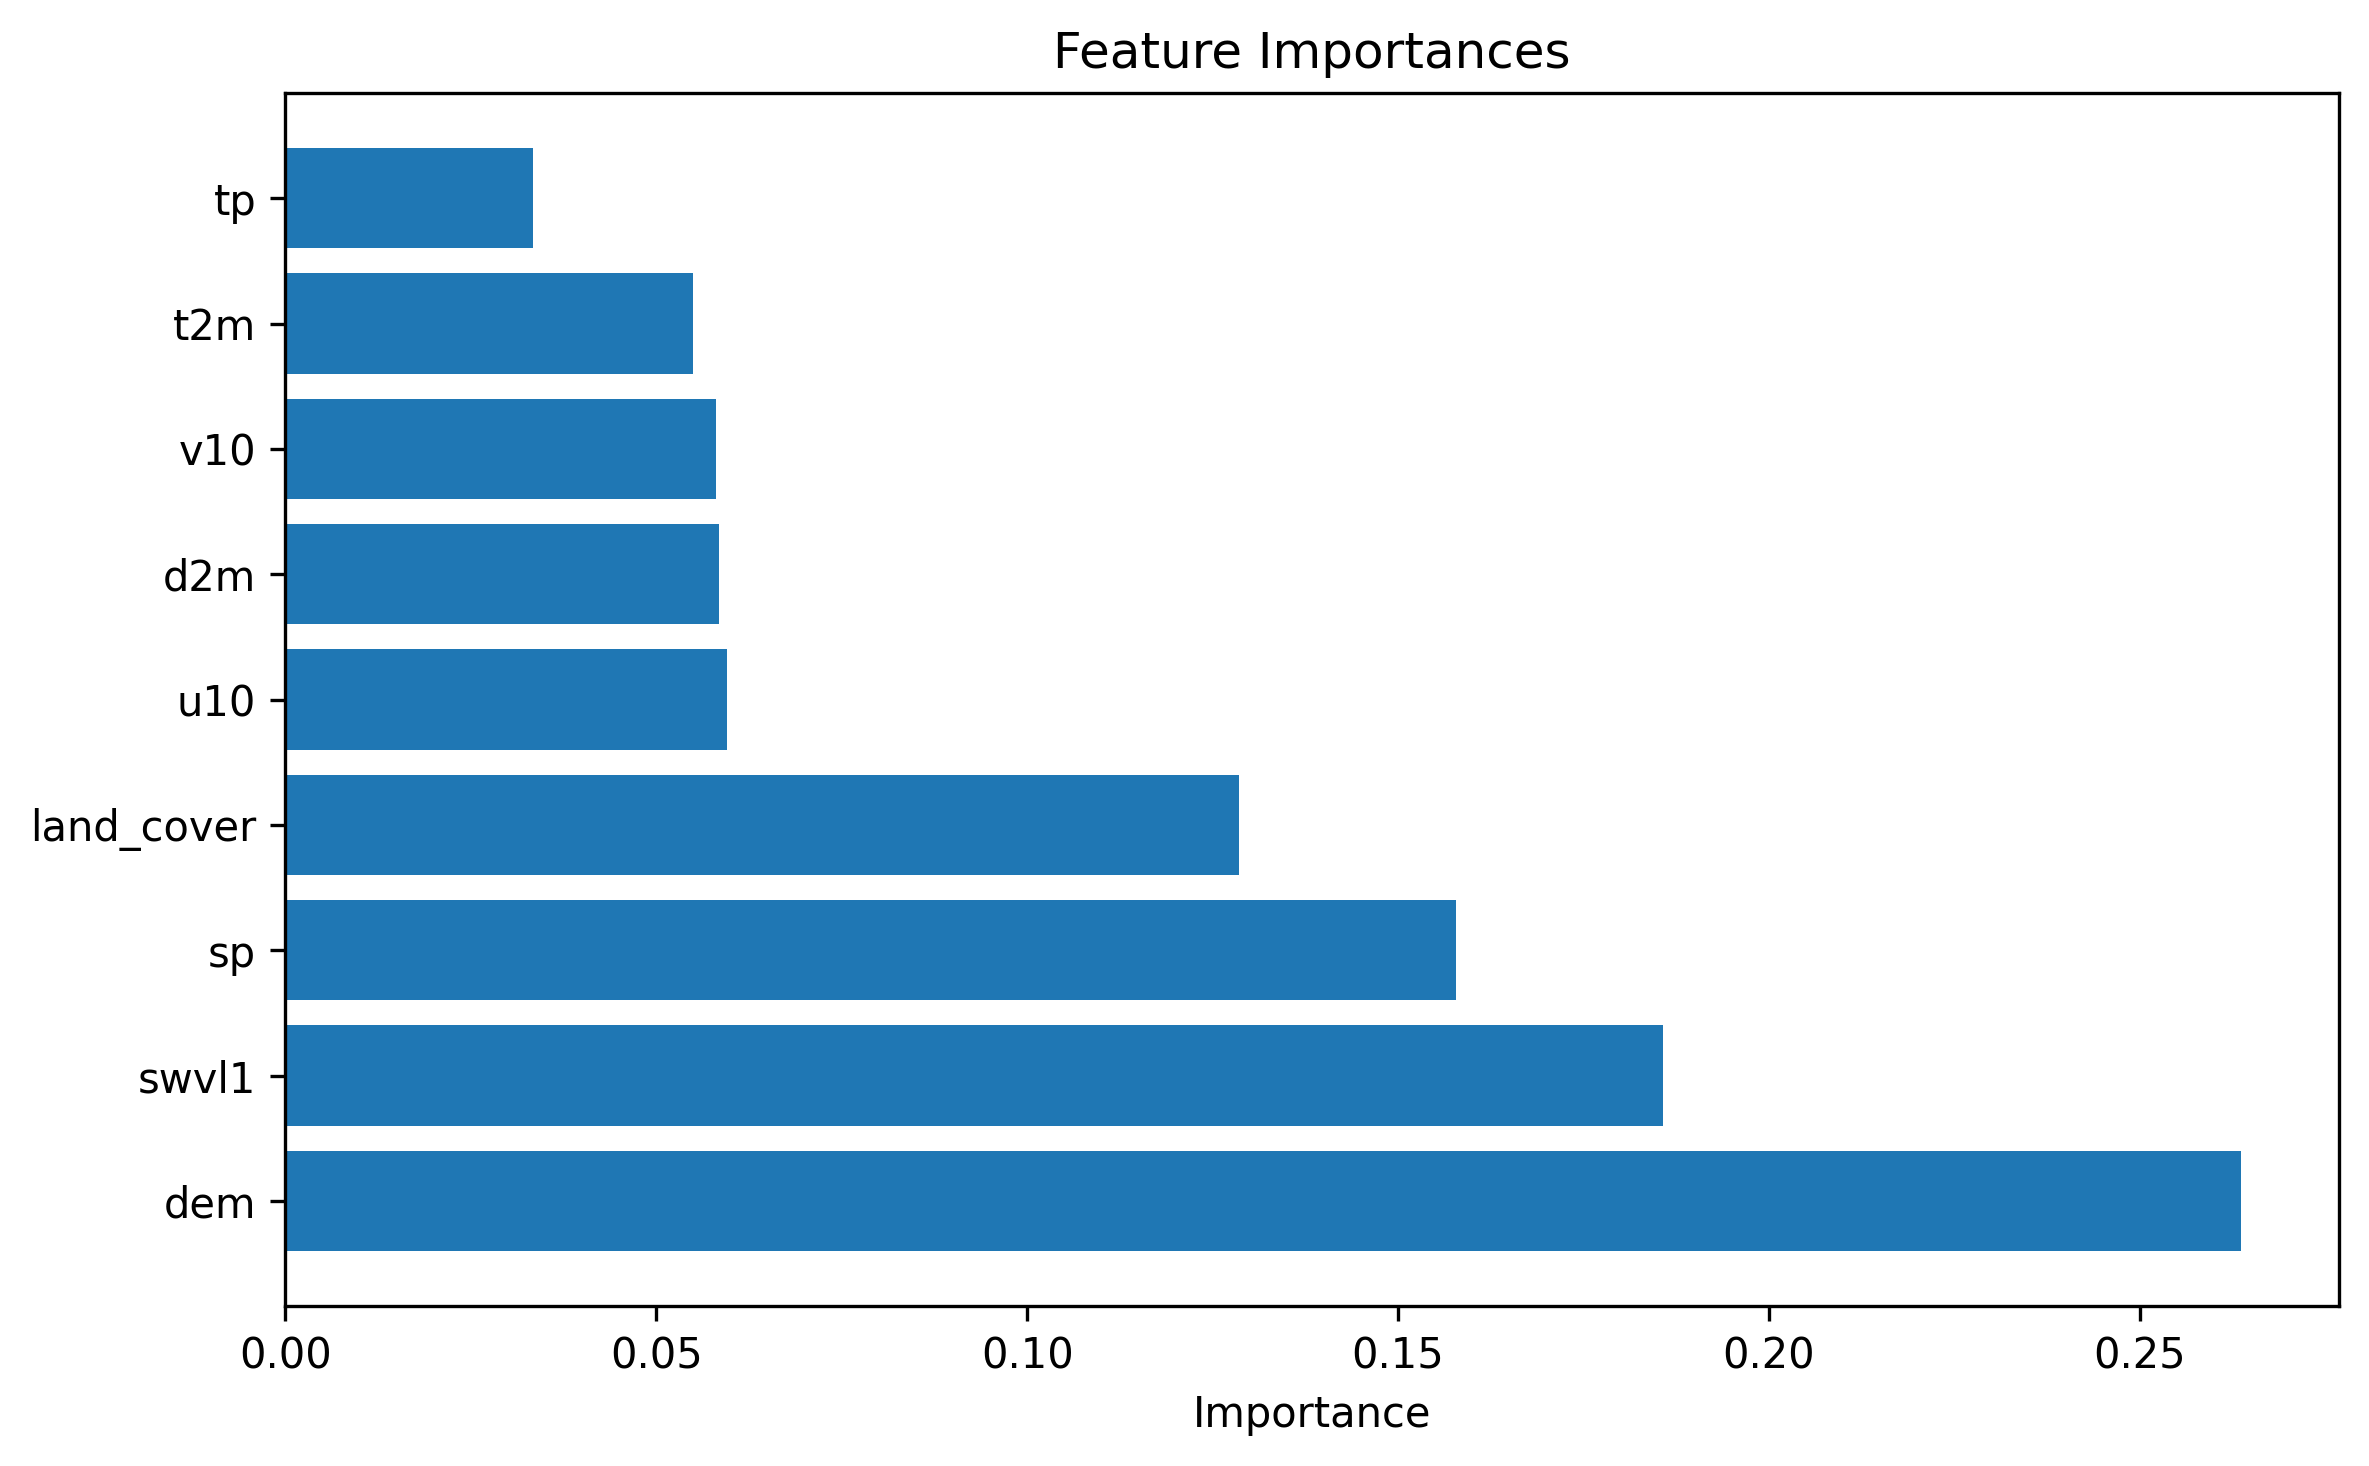

In [16]:
Image(filename=FIGURES_DIR /"rf_feature_importance.png")

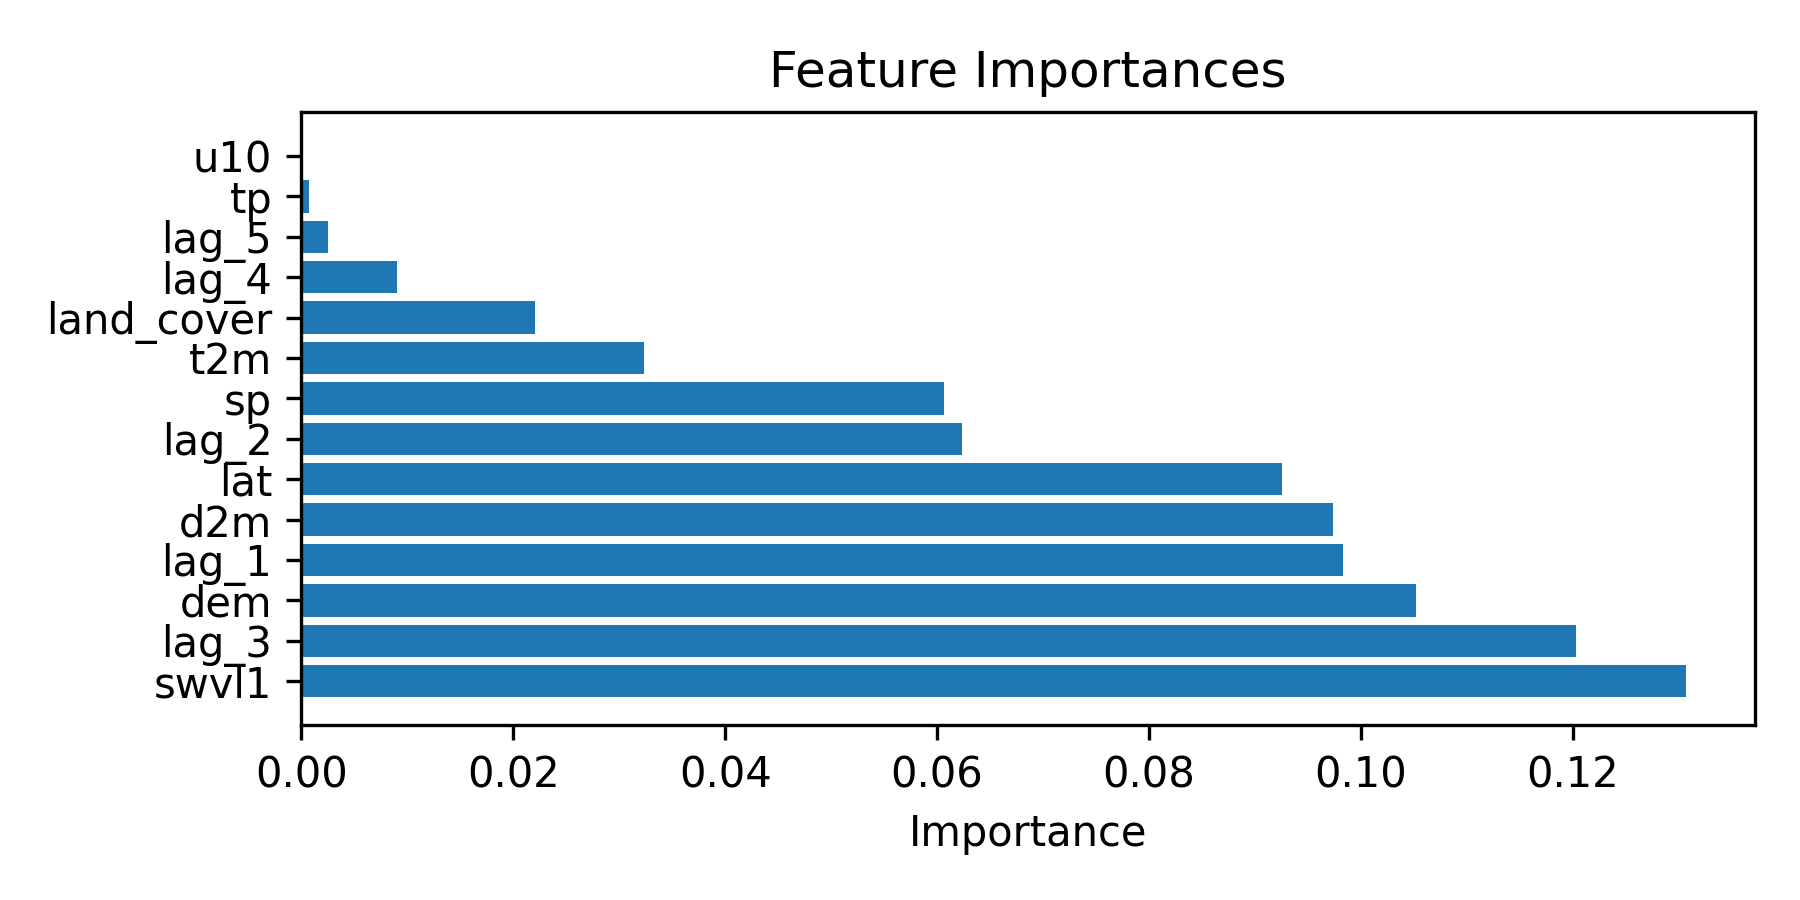

In [7]:
Image(filename="/anvil/scratch/x-ddominguez/figures/TabNet_Feature_Importance_with_burn_new.png")

**Figure 2.** TabNet feature importance for the Basic Features dataset and previous burn history, ranked in ascending order to highlight the most influential environmental and climatic variables in burn prediction.

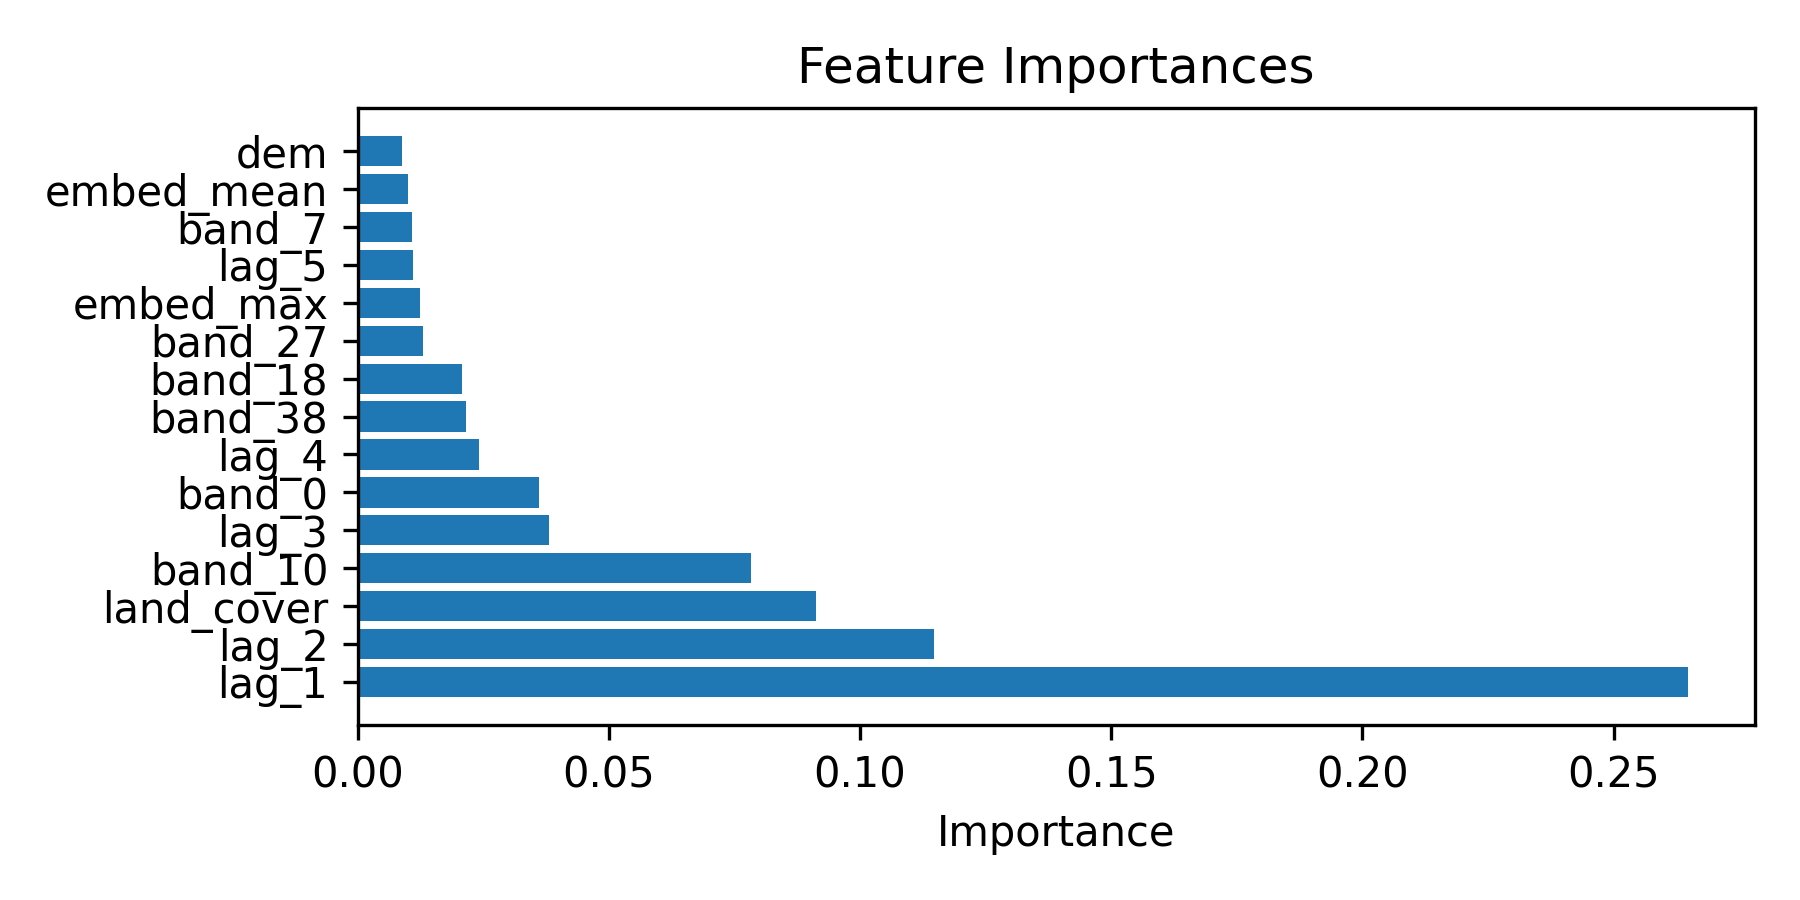

In [5]:
Image(filename="/anvil/scratch/x-ddominguez/figures/xgb_burn_embed_feature_importance.png")

**Figure 3.** XGBoost feature importance for basic features, previous burn history, and AlphaEarth embeddings, ranked in ascending order to highlight the most influential environmental and climatic variables in predicting burn occurrence.

### Application

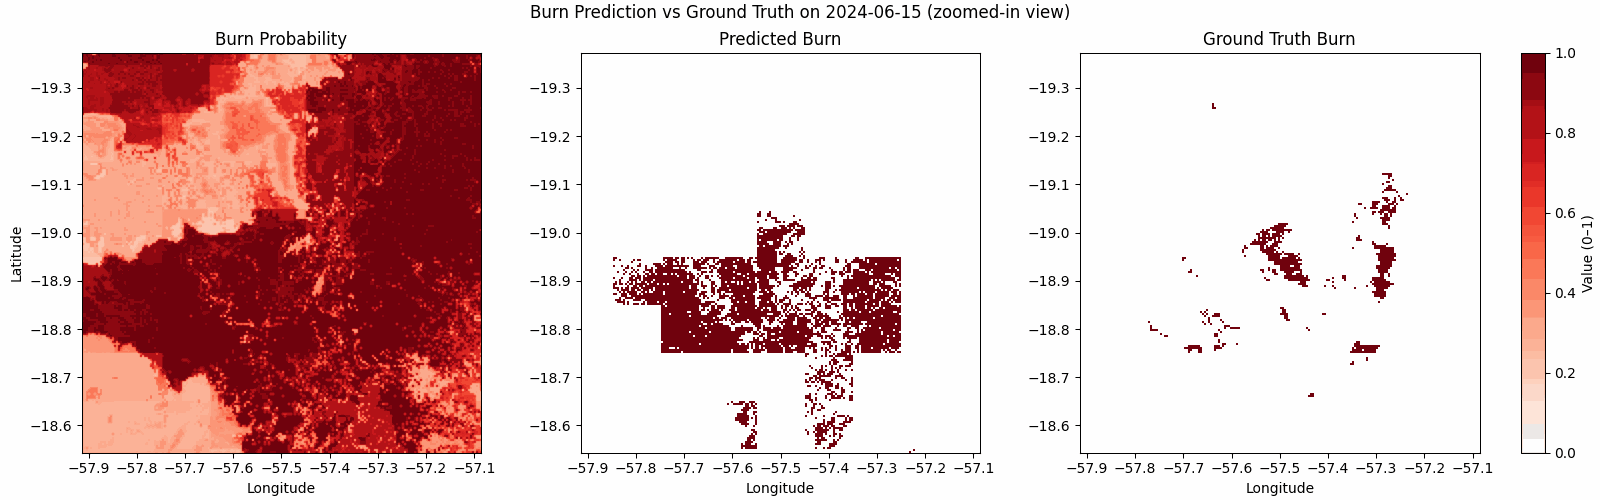

In [10]:
Image(filename="/anvil/scratch/x-ddominguez/rf_gif/rf_burn_prediction.gif")

**Figure 4.** Animated sequence of Random Forest burn probability predictions compared to ground truth across sequential days, cropped to the largest detected burn cluster for focused visualization.

## Feature Set: Basic Features + Previous Burn History

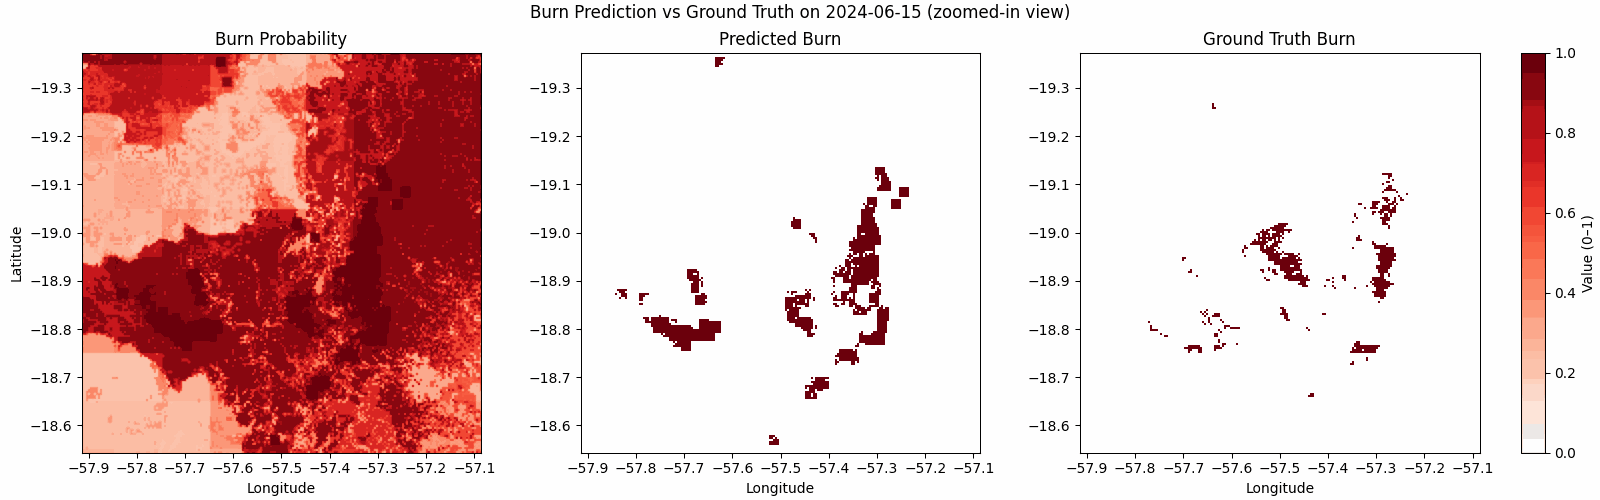

In [8]:
Image(filename="/anvil/scratch/x-ddominguez/rf_with_burn_gif/rf_with_burn_prediction.gif")

**Figure 5.** Animated sequence of Random Forest burn probability predictions compared to ground truth across sequential days, cropped to the largest detected burn cluster for focused visualization.

## Feature Set: Basic Features + Previoius Burn History + AlphaEarth Embedding

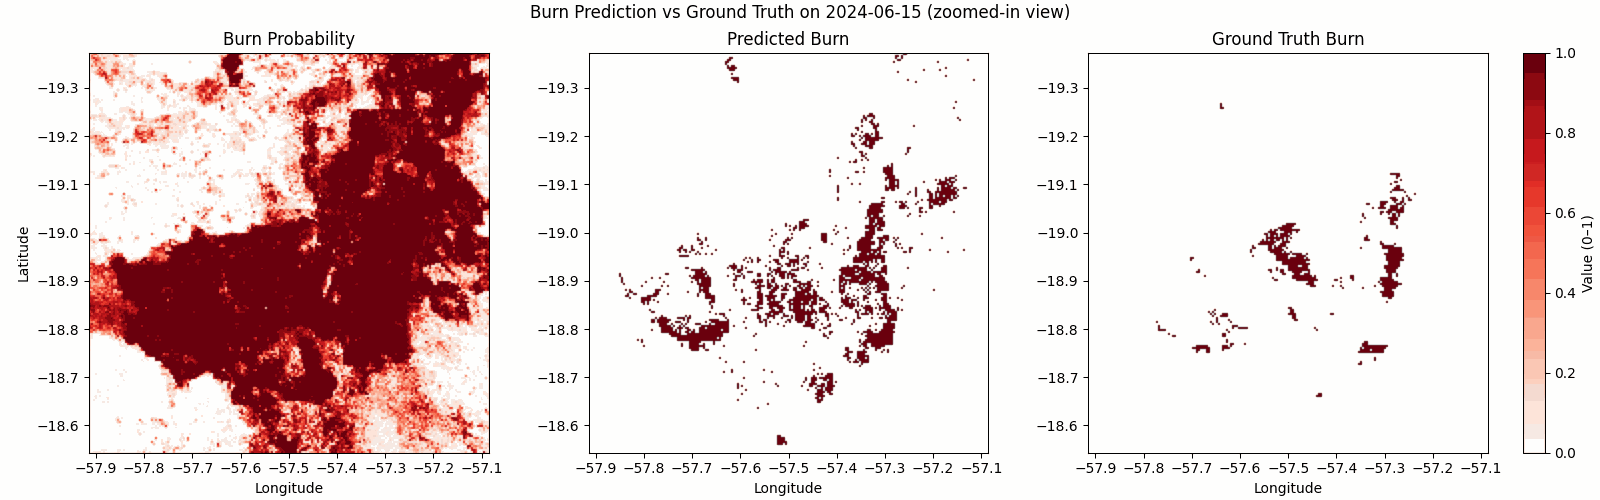

In [11]:
Image(filename="/anvil/scratch/x-ddominguez/XGB_embed_gif/xgb_burn_embed_prediction.gif")

 **Figure 6.** Animated sequence of XGBoost burn probability predictions compared to ground truth across sequential days, cropped to the largest detected burn cluster for focused visualization.

# Step 3: Residual ConvLSTM for Spatiotemporal Prediction

While the baseline model in Step 2 treats each pixel–day observation independently, wildfires are inherently spatiotemporal phenomena. Burn likelihood depends not only on the current environmental state but also on recent fire activity, weather patterns, and spatial continuity of fuels.

**Problem Setup**

In this step, we formulate the problem as a **spatiotemporal sequence classification task**:

$$
\hat{y} = f_\theta \big( X_{t-T+1}, X_{t-T+2}, \dots, X_t \big)
$$

Where:

* $X_t$ = Multichannel raster patch centered on the target pixel for day $t$
* $T$ = Number of past days used as context (sequence length)
* $\hat{y}$ = Predicted probability that the central pixel will burn on the next day ($t+1$)
* $f_\theta$ = Learnable model parameters (ResConvLSTM with SE)

**Key characteristics of this setup:**

* **Inputs**:
  * Sequences of environmental, climatic, and land-cover variables
  * Each input sample is a cube of shape $(C, T, H, W)$

    * $C$: Number of variables (temperature, precipitation, wind, soil moisture, elevation, land cover, prior burn mask)
    * $T$: Sequence length (e.g., 5 days)
    * $H, W$: Patch size in pixels (e.g., $7 \times 7$)

* **Output**:
  * A scalar burn probability for the central pixel of the patch for the day after the input sequence ends

* **Goal**:
  * Capture **short-term temporal dependencies** (e.g., heat waves, drying trends)
  * Incorporate **spatial context** (neighboring burns, terrain, vegetation)
  * Handle **class imbalance** between burn and non-burn cases

**Why this matters**:
By embedding the prediction in a spatiotemporal context, the model can learn progression patterns — for example, a burn scar moving in a particular direction under specific wind and fuel conditions — that are invisible to single-day, single-pixel approaches.

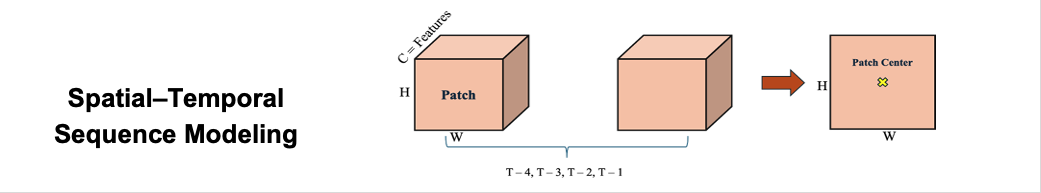

In [20]:
Image(filename=FIGURES_DIR / "spatial-Temporal.png")

In [3]:
# Training

In [ ]:
#Interpretation

In [4]:
# Application

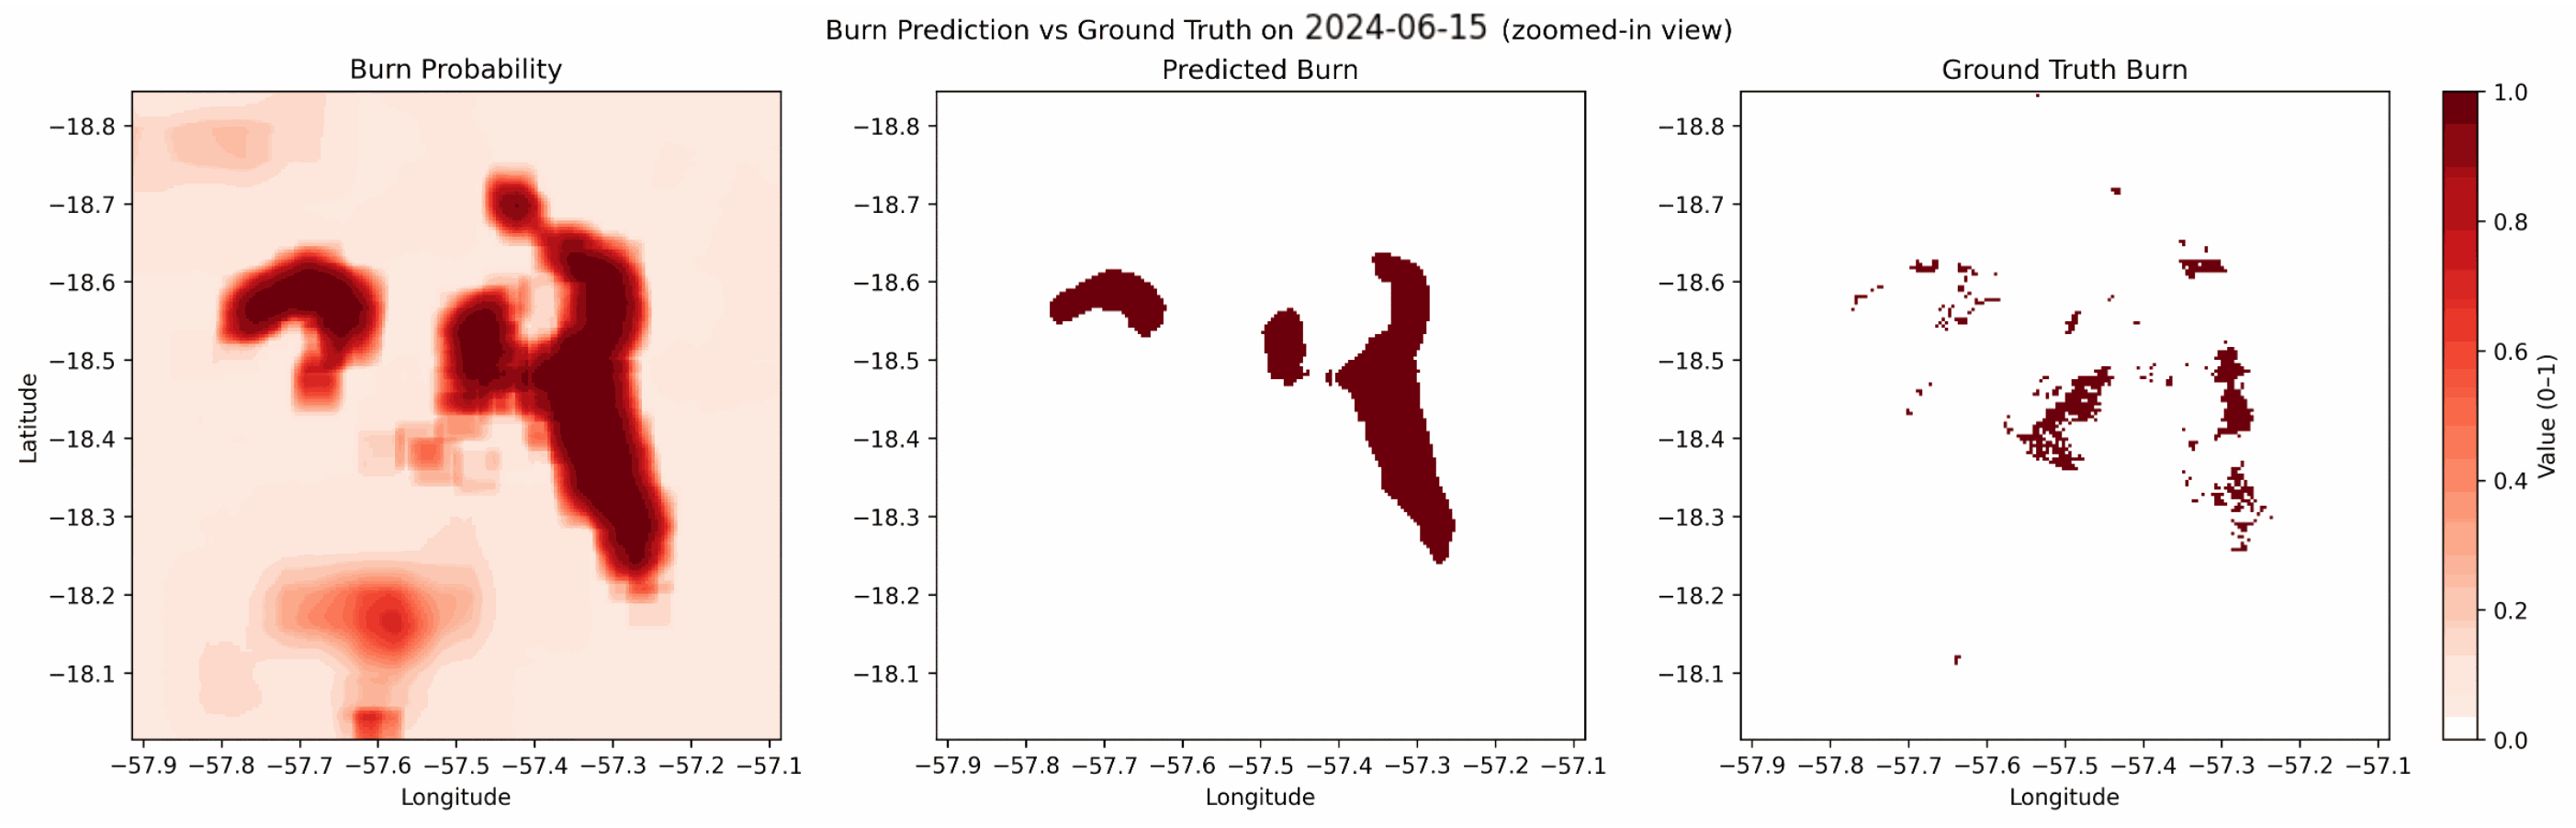

In [7]:
Image(filename="/anvil/scratch/x-ddominguez/burn_progresion_gif/progression_prediction.gif")

 **Figure .** Animated sequence of burn progression predictions compared to ground truth across sequential days, cropped to the largest detected burn cluster for focused visualization.

## Feature Set: Patch size 15 (Burn Progression)


| **Model**                   | **Precision** | **Recall** | **F1-Score** | **Date**    |
|----------------------------|---------------|------------|--------------|-------------|
| Burn Progression: ConvLSTM |               |            |              | 06/15/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/16/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/17/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/18/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/19/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/20/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/21/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/22/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/23/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/24/24    |
| Burn Progression: ConvLSTM |               |            |              | 06/25/24    |

In [5]:
# Interpretation

# Insights and discussions

## Insights

1. **Progressive Feature Enrichment Improves Performance**  
   Across all models, adding **previous burn history (PBH)** consistently improved recall and overall F1-score, confirming that spatial memory of past fires is a strong predictor in the Pantanal. The largest jump occurred when incorporating **AlphaEarth embeddings**, which significantly enhanced both precision and recall—suggesting these embeddings capture critical spatial–temporal patterns not present in raw environmental variables.

2. **Shift in Predictive Drivers with AlphaEarth Embeddings**  
   In the **Basic Features** model, static environmental variables—**elevation (`dem`)**, **soil moisture (`swvl1`)**, and **surface pressure (`sp`)**—dominated feature importance, highlighting the role of topography and hydrology in baseline fire risk. After adding embeddings and PBH, the top predictors shifted toward **spectral bands** (e.g., `band_14`, `band_23`, `band_46`), embedding-derived variables (`embed_min`), and **lag_5** (burn history), reflecting the added value of fine-scale Earth observation and temporal context.

3. **Model Performance Hierarchy**  
   - **XGBoost** achieved the highest precision, recall, and F1-scores across all feature sets, outperforming RF and TabNet in nearly every scenario.  
   - **Random Forest** remained competitive for simpler feature sets but plateaued in performance gains as complexity increased.  
   - **TabNet** results are pending, though its attention-based design suggests it may excel in leveraging embeddings for nuanced feature interactions.

4. **Feature Importance Patterns Across Models**  
   For RF and XGBoost without embeddings, **burn history**, **elevation (dem)**, **soil moisture (`swvl1`)**, and **land cover type** were consistently among the top predictors. With embeddings, feature importance rankings shifted toward spectral–temporal indicators, underscoring their ability to capture landscape condition and climatic gradients relevant to fire ignition and spread.



# Conclusions

1. **Progressive Feature Enrichment Improves Prediction**  
   - Adding **previous burn history (PBH)** consistently improved recall and overall F1-scores.  
   - Incorporating **AlphaEarth embeddings** provided the biggest gains, improving both precision and recall by capturing spatial–temporal patterns not present in raw climate and land-cover data.  

2. **Drivers of Burn Prediction Shift with Embeddings**  
   - Without embeddings, **topography (DEM)**, **soil moisture (swvl1)**, and **surface pressure (sp)** were dominant predictors.  
   - With embeddings, the importance shifted toward **spectral bands** and lagged burn features, highlighting how fine-scale EO data adds context to fire risk.  

3. **Model Hierarchy**  
   - **XGBoost** outperformed Random Forest and TabNet across all feature sets, offering the best tradeoff of precision and recall.  
   - **Random Forest** was competitive on simple features but plateaued with added complexity.  
   - **TabNet** showed potential for leveraging embeddings but lagged behind tree-based methods in current runs.  

4. **Spatiotemporal Modeling Advantage**  
   - The ConvLSTM model demonstrated its ability to capture **burn progression over time and space**, an improvement over pixel-day independent models.  
   - This highlights the need for spatiotemporal approaches in operational wildfire forecasting.  

5. **Implications for Fire Management**  
   - Models confirm the critical role of **fire memory (previous burns)** in predicting new ignitions.  
   - Incorporating **EO embeddings and sequence models** can enhance early warning systems and resource allocation, supporting proactive wildfire management in the Pantanal.  


# References

[1] [Carbon Brief](https://www.carbonbrief.org/climate-change-made-the-supercharged-2024-pantanal-wildfires-40-more-intense/). (2024, August 8).

[2] [World Weather Attribution](https://www.worldweatherattribution.org/hot-dry-and-windy-conditions-that-drove-devastating-pantanal-wildfires-40-more-intense-due-to-climate-change/). (2024, August 8).

[3] Masrur, A., & Yu, M. (2023). [*ConvLSTM networks for predicting and physically interpreting wildfire spread*](https://www.sciencedirect.com/science/article/abs/pii/B9780323917377000098). In *Artificial Intelligence in Earth Science* (pp. 119–156). Elsevier.

[4] Masrur, A., Yu, M., & Taylor, A. (2024). [*Capturing and interpreting wildfire spread dynamics: attention-based spatiotemporal models using ConvLSTM networks*](https://www.sciencedirect.com/science/article/pii/S1574954124003029). *Ecological Informatics, 82*, 102760.
